# Labeling a full WSI using stardist and dask for distributed computation

## Load the test image

In [1]:
import sys
sys.path.insert(0, "..")

In [2]:
import relabel

In [3]:
import numpy as np
import zarr
import dask.array as da
import matplotlib.pyplot as plt

In [4]:
from dask.diagnostics import ProgressBar

Segment and label a full image of a mouse embryo from the Image Data Repository (IDR) https://idr.github.io/ome-ngff-samples/

In [5]:
file_url = "https://uk1s3.embassy.ebi.ac.uk/idr/zarr/v0.1/6001253.zarr"
z_arr = zarr.open(file_url, mode="r")

Visualize the image DAPI staining channel

In [6]:
z_arr["0"].info

Name,/0
Type,zarr.core.Array
Data type,>u2
Shape,"(1, 2, 297, 1024, 803)"
Chunk shape,"(1, 1, 1, 1024, 803)"
Order,C
Read-only,True
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.FSStore
No. bytes,976859136 (931.6M)
Chunks initialized,0/594


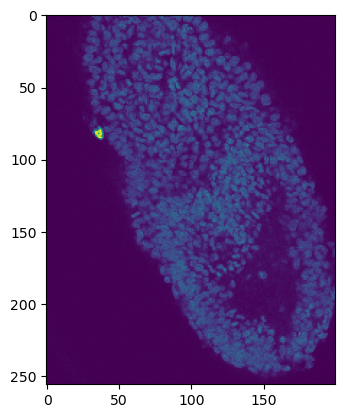

In [7]:
plt.imshow(z_arr["2"][0, 1, 100, ...])

## Load the StarDist models

In [17]:
# Dimension reduction and clustering libraries
from stardist.models import StarDist2D, StarDist3D
from csbdeep.utils import normalize

def stardist3d(im_chunk, model=None):
    labeled_image, _ = model.predict_instances(normalize(im_chunk, 1,99.8, axis=(0, 1, 2)))
    labeled_image = labeled_image.astype(np.int32)
    return labeled_image

model_3D = StarDist3D.from_pretrained("3D_demo")

Found model '3D_demo' for 'StarDist3D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.707933, nms_thresh=0.3.


## Try now with the 3D segmentation

Using the DAPI channel of all z-stacks

In [18]:
img_da = da.from_zarr(file_url, component="2")
print(img_da)
img_da = img_da[0, 1, 112:116, ...]
img_da = da.rechunk(img_da, (4, 256, 256))
print(img_da)

dask.array<from-zarr, shape=(1, 2, 297, 256, 200), dtype=>u2, chunksize=(1, 1, 1, 256, 200), chunktype=numpy.ndarray>
dask.array<rechunk-merge, shape=(4, 256, 200), dtype=>u2, chunksize=(4, 256, 200), chunktype=numpy.ndarray>


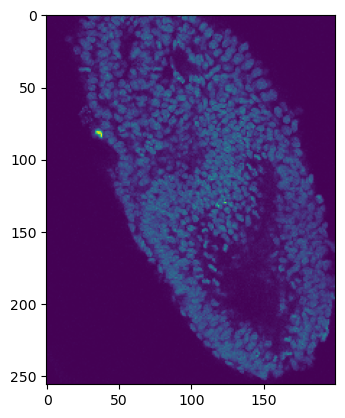

In [19]:
plt.imshow(img_da[0, ...])

## Execute the segmentation and relabeling process

In [20]:
%%time
labels = relabel.image2labels(
    img_da,
    seg_fn=stardist3d,
    overlaps=[4, 8, 8],
    ndim=3,
    cache_dir=".",
    segmentation_fn_kwargs={"model": model_3D}
)

CPU times: total: 11.6 s
Wall time: 3.48 s


In [21]:
labels

dask.array<_trim, shape=(4, 256, 200), dtype=int32, chunksize=(4, 256, 200), chunktype=numpy.ndarray>

In [22]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    labels.to_zarr("./labeled_3D.zarr", compressor=zarr.Blosc(clevel=5), overwrite=True)

[########################################] | 100% Completed | 122.50 ms


In [23]:
labels = da.from_zarr("./labeled_3D.zarr")

In [28]:
labels.max().compute()

0

In [24]:
with ProgressBar():
    label_ref = stardist3d(img_da.compute(), model=model_3D)

[                                        ] | 0% Completed | 485.04 ms

[########################################] | 100% Completed | 695.12 ms


In [25]:
label_ref.shape

(4, 256, 200)

In [26]:
label_ref.max()

0